In [1]:
import numpy as np
import phate, magic
import scprep, scanpy
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import spearmanr, pearsonr
import pandas as pd
import leidenalg
from sklearn.preprocessing import scale

In [2]:
import sys, torch
sys.path.append('~/bin/AAnet/') ## install AAnet in local bin directory (https://github.com/KrishnaswamyLab/AAnet)
from AAnet_torch import *
from torch import nn, optim

In [3]:
trajectory_data = np.load('../data/splatter_simulated_data.npz')
data = trajectory_data['data']
true_counts = trajectory_data['true_counts']
true_lib_size = true_counts.T.sum(axis=1)
time = trajectory_data['pseudotime'] / 10000

In [4]:
cell_phate_op = phate.PHATE(random_state=1234, verbose=False)
true_cell_data_phate = cell_phate_op.fit_transform(true_counts)
true_cell_data_phate = true_cell_data_phate * [-1, 1]

In [5]:
names = ['GSPA_QR', 'DiffusionEMD', 'MAGIC', 'Signals', 'GSPA', 'GAE_att_Ggene',
       'GAE_noatt_Ggene', 'Node2Vec_Ggene', 'Eigenscore', 'GFMMD', 'SIMBA', 'siVAE']

In [6]:
adata = scanpy.AnnData(true_counts)

/tmp/ipykernel_462166/111823185.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = scanpy.AnnData(true_counts)


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


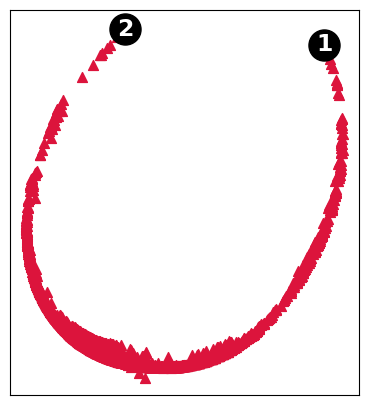

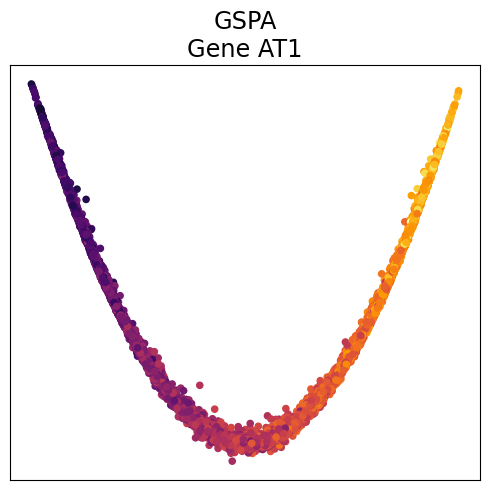

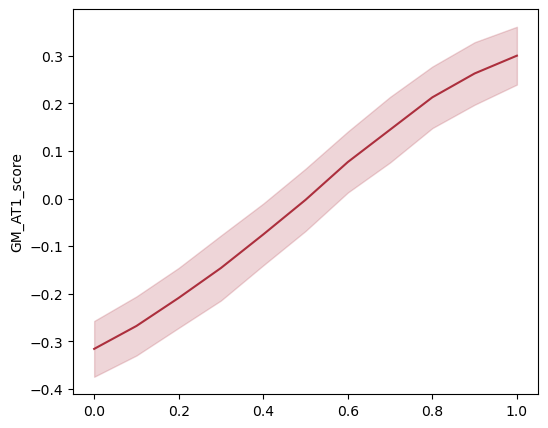

<Figure size 640x480 with 0 Axes>

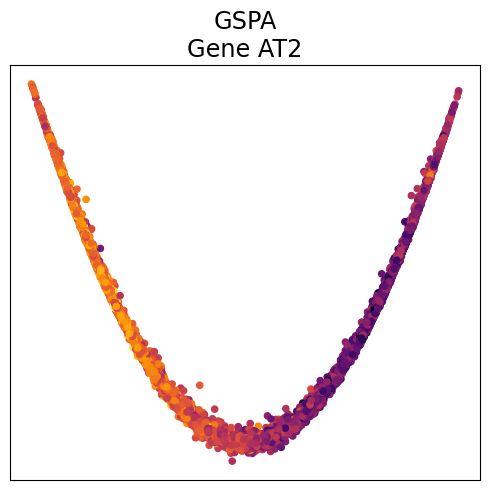

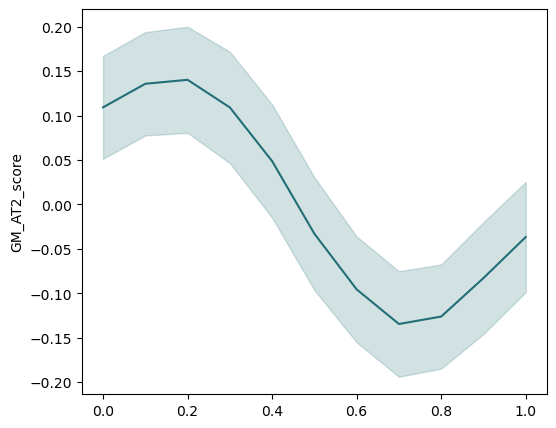

<Figure size 640x480 with 0 Axes>

In [18]:
for method in ['GSPA']:
    results = np.load(f'results/{method}/0_results.npz')
    
    gene_phate_op = phate.PHATE(random_state=1234, verbose=False)
    gene_data_phate = gene_phate_op.fit_transform(results['signal_embedding'])

    """
    AAnet
    """
    N_ARCHETYPES = 2
    try:
        extrema = torch.Tensor(utils.get_laplacian_extrema(gene_phate_op.graph.data_nu, n_extrema=N_ARCHETYPES, subsample=False)).numpy().astype(int)
        extrema = torch.Tensor(gene_phate_op.graph.data_nu[extrema])
    except nx.NetworkXError: # graph disconnected
        extrema = None
    device = torch.device('cpu')    
    model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                                 n_archetypes=N_ARCHETYPES, 
                                 input_shape=gene_phate_op.graph.data_nu.shape[1],
                                 device=device, 
                                 diffusion_extrema=extrema
                                )
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    data_loader = torch.utils.data.DataLoader(gene_phate_op.graph.data_nu, batch_size=256, shuffle=True, num_workers=4)
    for i in range(72):
        loss, r_loss, a_loss=utils.train_epoch(model, data_loader, optimizer, epoch=i, gamma_extrema=1)
        archetypal_embedding = model.encode(torch.Tensor(gene_phate_op.graph.data_nu))
    
    archetypal_embedding = model.encode(torch.Tensor(gene_phate_op.graph.data_nu))
    barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()
    pc_ats = model.decode(model.get_n_simplex(model.n_archetypes).type(torch.float)).cpu().detach().numpy()
    data_ats = pc_ats @ gene_phate_op.graph.data_pca.components_
    phate_ats = gene_phate_op.transform(pc_ats)
    
    # VISUALIZE ARCHETYPES
    fig, ax = plt.subplots(figsize=(4.5,5))
    scprep.plot.scatter2d(gene_data_phate, c='crimson', fontsize=25, colorbar=False, ax=ax, s=50, marker='^', dpi=200)
    scprep.plot.scatter2d(phate_ats, ax=ax, c='black', s=500, colorbar=False, alpha=1, ticks=None)
    for t,coord in enumerate(phate_ats):
            ax.text(coord[0], coord[1], s=t+1, horizontalalignment='center',
                            verticalalignment='center', fontdict={'color': 'white','size':17,'weight':'bold'}, zorder=4)
    
    fig.savefig(f'figures/{method}_gene_archetypes.png', dpi=500)
    
    """
    ENRICHMENT
    """
    genes_near_at1 = np.argsort(barycentric_archetypal_embedding[:, 0])[::-1][:50]
    genes_near_at2 = np.argsort(barycentric_archetypal_embedding[:, 1])[::-1][:50]
    
    scanpy.tl.score_genes(adata, gene_list=adata.var_names[adata.var_names.astype(int).isin(genes_near_at1)],
                          random_state=0, score_name=f'GM_AT1_score',
                          n_bins=int(adata.n_vars * 0.25))
    
    scprep.plot.scatter2d(true_cell_data_phate,
                          c=adata.obs[f'GM_AT1_score'], colorbar=False, s=20,
                          title=method + f'\nGene AT1', figsize=(5,5), ticks=None,
                          filename=f'figures/{method}_gene_at1.png')
    
    fig = plt.figure(figsize=(6,5))
    signal = adata.obs[f'GM_AT1_score']
    sns.lineplot(x=np.round(time, 1), y=signal, color='#AC2F3D', errorbar='sd')
    fig.savefig(f'figures/{method}_gene_AT1_over_time.png', dpi=200)
    plt.show(); plt.clf()
    
    scanpy.tl.score_genes(adata, gene_list=adata.var_names[adata.var_names.astype(int).isin(genes_near_at2)],
                          random_state=0, score_name=f'GM_AT2_score',
                          n_bins=int(adata.n_vars * 0.25))
    
    scprep.plot.scatter2d(true_cell_data_phate,
                          c=adata.obs[f'GM_AT2_score'], colorbar=False,
                          title=method + f'\nGene AT2', ticks=None, s=20, figsize=(5,5),
                          filename=f'figures/{method}_gene_at2.png', dpi=200)
    
    fig = plt.figure(figsize=(6,5))
    signal = adata.obs[f'GM_AT2_score']
    sns.lineplot(x=np.round(time, 1), y=signal, color='#216E76', errorbar='sd')
    fig.savefig(f'figures/{method}_gene_AT2_over_time.png', dpi=200)
    plt.show(); plt.clf()